<a href="https://colab.research.google.com/github/ssv273/computer_vision/blob/master/HW_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обработка видео
Классификация действий по видео


## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tqdm.notebook import tqdm

import gc


In [3]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

     |████████████████████████████████| 2.3MB 3.3MB/s 


## Загрузка и распаковка датасета KTH

In [4]:
if 1:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

--2020-05-03 01:21:39--  http://www.nada.kth.se/cvap/actions/walking.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2020-05-03 01:21:40--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.227.116
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.227.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘walking.zip’

walking.zip             [    <=>             ] 231.21M  7.97MB/s    in 32s     

2020-05-03 01:22:12 (7.32 MB/s) - ‘walking.zip’ saved [242442411]

--2020-05-03 01:22:14--  http://www.nada.kth.se/cvap/actions/jogging.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::

In [0]:
!rm *.zip

## Подготовка датасета для классификации

In [6]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [7]:
SUBSET_LEN = 200
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))

Dataset samples (subset): 200


посмотрим на размеры наших видеофайлов

In [8]:
%%time
shapes = []
for i in range(len(dataset)):
    videodata = skvideo.io.vread(dataset[i][0])
    shapes.append(videodata.shape)

CPU times: user 3.55 s, sys: 4.71 s, total: 8.26 s
Wall time: 39.1 s


In [9]:
print('Всего файлов {}\nМинимальное количество кадров {}\nМаксимальное количетво кадров {}'.format(len(shapes),sorted(shapes)[0][0], sorted(shapes)[-1][0]))

Всего файлов 200
Минимальное количество кадров 280
Максимальное количетво кадров 1092


как мы видим - у нас разное количество кадров в роликах, есть совсем маленькие, есть совсем большие

итак, что мы сделаем: мы возьмем ролики и повторим каждый из них до максимального количества кадров

In [10]:
MAX_FRAMES = sorted(shapes)[-1][0]
MAX_FRAMES

1092

Напишем функцию, которая будет повторять ролик сам в себя до необходимого нам количества раз

In [0]:
def reshape_(np_video):
  tmp = np_video.copy()
  # если количество кадров в видео меньше максимального
  if np_video.shape[0] < MAX_FRAMES:
    # то определяем сколко раз надо повторить операцию vstack
    num_iter = round(MAX_FRAMES / np_video.shape[0]) + 1
    # создаем временный файл, в котором будем хранить повторы
    tmp = np_video.copy()
    # стакаем необходимое количество раз
    for iterations in range(num_iter):
      tmp = np.vstack((tmp, np_video))
      # print(tmp.shape, MAX_FRAMES)
      if tmp.shape[0] > MAX_FRAMES:
        break
    # так как мы повторяли ролик сам в себя несколько раз, то его длина может быть больше чем необходимая
    # поэтому возьмем только необходимое нам количество кадров
    tmp = tmp[:MAX_FRAMES, ...]
  return tmp

Теперь преобразуем каждый ролик до нужного нам размера и запишем его

In [12]:
for data in tqdm(dataset):
  path = data[0][:-3]
  np_video = skvideo.io.vread(data[0])
  new_video = reshape_(np_video)
  skvideo.io.vwrite(path + "mp4", new_video)

Теперь сделаем новый датасет

In [13]:
dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.mp4')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [15]:
%%time
shapes = []
for i in range(len(dataset)):
    videodata = skvideo.io.vread(dataset[i][0])
    shapes.append(videodata.shape)

CPU times: user 9.44 s, sys: 10.9 s, total: 20.3 s
Wall time: 1min 21s


In [16]:
print('Всего файлов {}\nМинимальное количество кадров {}\nМаксимальное количетво кадров {}'.format(len(shapes),sorted(shapes)[0][0], sorted(shapes)[-1][0]))

Всего файлов 200
Минимальное количество кадров 1092
Максимальное количетво кадров 1092


Ну вот, чего мы собственно и добивались

## Визуализация кадра из видео

videodata shape: (1092, 120, 160, 3)


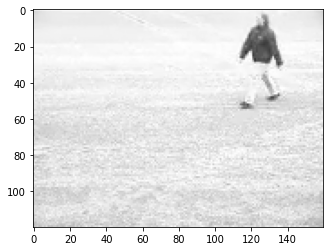

In [18]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...]);

## Визуализация "движения"

motion shape: (1091, 120, 160, 1)


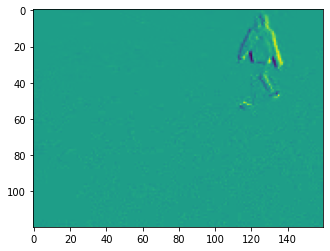

In [19]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

# Создание датасета

In [0]:
train_x = train_x.astype(np.float32) / 255.

In [0]:
BATCH_SIZE = 16
NUM_EPOCHS = 10

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

# Сегодня доделаю
